In [127]:
import pandas as pd
import numpy as np
import numpy_financial as npf
from pandas_datareader import data as wb
import datetime
import requests
from scipy.stats.mstats import gmean
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [128]:
start_time = datetime.datetime.now() # Замер времени выполнения скрипта для одного тикера

In [129]:
COMPANY = 'GE'
KEY = '2105b9f242d47b69fc73f0f2205be048'

In [130]:
IS = requests.get(f'https://financialmodelingprep.com/api/v3/income-statement/{COMPANY}?apikey={KEY}').json()
FIS = requests.get(f'https://financialmodelingprep.com/api/v3/financials/income-statement/{COMPANY}?apikey={KEY}').json()
BL = requests.get(f'https://financialmodelingprep.com/api/v3/balance-sheet-statement/{COMPANY}?apikey={KEY}').json()
RT = requests.get(f'https://financialmodelingprep.com/api/v3/ratios/{COMPANY}?apikey={KEY}').json()
CF = requests.get(f'https://financialmodelingprep.com/api/v3/cash-flow-statement/{COMPANY}?apikey={KEY}').json()
EV = requests.get(f'https://financialmodelingprep.com/api/v3/enterprise-values/{COMPANY}?apikey={KEY}').json()
PF = requests.get(f'https://financialmodelingprep.com/api/v3/profile/{COMPANY}?apikey={KEY}').json()
CQ = requests.get(f'https://financialmodelingprep.com/api/v3/quote/{COMPANY}?apikey={KEY}').json()
FS = requests.get(f'https://financialmodelingprep.com/api/v3/financial-statement-full-as-reported/{COMPANY}?apikey={KEY}').json()
KM = requests.get(f'https://financialmodelingprep.com/api/v3/key-metrics/{COMPANY}?apikey={KEY}').json()

In [131]:
    financial_income_statement = pd.DataFrame(FIS['financials'])
    income_statement = pd.DataFrame(IS)
    balance = pd.DataFrame(BL)
    ratios = pd.DataFrame(RT)
    cash_flow = pd.DataFrame(CF)
    enterprise_value = pd.DataFrame(EV)
    company_profile = pd.DataFrame(PF)
    real_time_quote = pd.DataFrame(CQ)
    financial_statement = pd.DataFrame(FS)
    key_metrics = pd.DataFrame(KM)

In [132]:
LTGrowth = 0.02
LTdis = 0.08
PRICE = real_time_quote['price'][0]
company_profile_beta = company_profile['beta']
Total_rating = []

In [133]:
work_table = pd.concat(
        (income_statement[['date', 'revenue', 'operatingIncome', 'netIncome', 'eps', 'ebitda',
                          'depreciationAndAmortization', 'interestExpense']].replace(np.nan, 0)[0:10],
        balance[['totalAssets', 'totalLiabilities', 'totalStockholdersEquity',
                        'totalDebt']].replace(np.nan, 0)[0:10],
        ratios[['dividendPayoutRatio', 'dividendYield', 'effectiveTaxRate', 'payoutRatio']].replace(
            np.nan, 0)[0:10],
        cash_flow[['freeCashFlow', 'dividendsPaid']].replace(np.nan, 0)[0:10],
        enterprise_value[['numberOfShares', 'stockPrice']].replace(np.nan, 0)[0:10],
        key_metrics[['debtToEquity', 'bookValuePerShare', 'roe', 'currentRatio']].replace(np.nan,
                                                                                          0)[0:10],
        financial_income_statement['Dividend per Share'].replace(np.nan, 0)[0:10]

        ),axis=1)

In [134]:
print(work_table)

         date       revenue  operatingIncome    netIncome       eps  \
0  2019-12-31   95215000000       3470000000  -4979000000  0.284460   
1  2018-12-31   97012000000     -17537000000 -22354000000 -0.741000   
2  2017-12-31   99279000000      -8470000000  -8484000000 -0.192700   
3  2016-12-31  119468000000      10223000000   7500000000  0.581040   
4  2015-12-31  115158000000       8141000000  -6126000000  0.282140   
5  2015-02-27  148589000000      15457000000  19001000000  0.015233   
6  2014-12-31  147811000000      17824000000  15233000000  1.480000   
7  2013-12-31  142937000000      15669000000  13057000000  1.280000   
8  2012-12-31  147359000000      18217000000  13641000000  1.470000   
9  2011-12-31  147300000000      20798000000  14151000000  1.230000   

        ebitda  depreciationAndAmortization  interestExpense   totalAssets  \
0   -110000000                 5.595000e+09              0.0  266048000000   
1 -16355000000                 6.582000e+09              0.0  

Расчет показателей качества

In [135]:
# считаем рост выручки______________________________________________________________
revenue_growth = round((((work_table['revenue'][0]/work_table['revenue'][9]) ** 0.1) -1), 2)

print(f'revenue_growth {revenue_growth}')


if revenue_growth > 0.06:
    revenue_growth_rating = 1
elif 0.05 > revenue_growth > 0.02:
    revenue_growth_rating = 0
else:
    revenue_growth_rating = -1

Total_rating.append(revenue_growth_rating)

# считаем Использование прибыли______________________________________________________________
average_dividend_payout_percentage = np.mean(work_table['dividendYield'][0:])

# average_percentage_of_buyback  # не найден   !!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

SHAREHOLDERS_EQUITY = (work_table['totalAssets'] - work_table['totalLiabilities'])

average_quity_SHAREHOLDERS_EQUITY = round((((SHAREHOLDERS_EQUITY[0] / SHAREHOLDERS_EQUITY[9]) ** 0.1) -1), 2)

use_of_profit = round((average_dividend_payout_percentage + average_quity_SHAREHOLDERS_EQUITY), 2)

print(f'use_of_profit {use_of_profit}')

if use_of_profit < 0.06:
    use_of_profit_rating = -2
elif 0.1 < use_of_profit > 0.06:
    use_of_profit_rating = 0
else:
    use_of_profit_rating = 2

Total_rating.append(use_of_profit_rating)

# Считаем Операционную маржу_________________________________________________________________

OPERATING_MAR = work_table['operatingIncome']/work_table['revenue']

operating_margin = round(np.mean(OPERATING_MAR[0:]), 2)

print(f'operating_margin {operating_margin}')

if operating_margin < 0.06:
    operating_margin_rating = -2
elif 0.14 > operating_margin > 0.06:
    operating_margin_rating = 0
else:
    operating_margin_rating = 2

Total_rating.append(operating_margin_rating)

# Считаем Динамику операционной маржи_________________________________________________________________

if OPERATING_MAR.std() < 0.1:
    operating_margin_dynamics = 'Рост'
    operating_margin_dynamics_rating = 2
else:
    operating_margin_dynamics = 'Падение'
    operating_margin_dynamics_rating = -2

Total_rating.append(operating_margin_dynamics_rating)

print(f'operating_margin_dynamics {operating_margin_dynamics}')

# Считаем Маржу чистой прибыли_________________________________________________________________

NET_PROFIT_MAR = work_table['netIncome']/work_table['revenue']

net_profit_margin = round(np.mean(NET_PROFIT_MAR[0:]), 2)

print(f'net_profit_margin {net_profit_margin}')

if net_profit_margin < 0.06:
    net_profit_margin_rating = -2
elif 0.1 > net_profit_margin > 0.06:
    net_profit_margin_rating = 0
else:
    net_profit_margin_rating = 2

Total_rating.append(net_profit_margin_rating)

# Считаем Динамику маржи чистой прибыли_________________________________________________________________

if NET_PROFIT_MAR.std() < 0.1 :
    net_profit_margin_dynamics = 'Рост'
    net_profit_margin_dynamics_rating = 1
else:
    net_profit_margin_dynamics = 'Падение'
    net_profit_margin_dynamics_rating = -1

Total_rating.append(net_profit_margin_dynamics_rating)

print(f'net_profit_margin_dynamics {net_profit_margin_dynamics}')

# Считаем Рост EPS_________________________________________________________________

EPS_growth = round((((work_table['eps'][0]/work_table['eps'][9]) ** 0.1) -1), 2)   # Первый вариант, eps - берем из API

# EPS_growth = round((((SHAREHOLDERS_EQUITY[0] / SHAREHOLDERS_EQUITY[9]) ** 0.1) -1), 2)  # Второй вариант, eps = totalAssets - totalLiabilities

#  !!!!!!!!!!!!!!!!!При разных вариантах разные значения!!!!!!!!!!!!!!!!!!!!!!

print(f'EPS_growth {EPS_growth}')

if EPS_growth < 0.06:
    EPS_growth_rating = -2
elif 0.1 > EPS_growth > 0.06:
    EPS_growth_rating = 0
else:
    EPS_growth_rating = 2

Total_rating.append(EPS_growth_rating)

# Считаем Уровень долга_________________________________________________________________

debt_level = round(np.mean(work_table['totalLiabilities']/work_table['totalAssets']), 2)

print(f'debt_level {debt_level}')

if debt_level < 0.5:
    debt_level_rating = 1
elif 0.7 > debt_level > 0.5:
    debt_level_rating = 0
else:
    debt_level_rating = -1

Total_rating.append(debt_level_rating)

 # ___________________________________ ROE_DuPont _______________________________________________

Profitability = []
TechnicalEfficiency = []
FinancialStructure = []

for year in range(0, 10):
    last_year = year + 1
    Profitability.append(work_table['netIncome'][year] / work_table['revenue'][year])
    TechnicalEfficiency.append(work_table['revenue'][year] / (
            (work_table['totalAssets'][year] + balance['totalAssets'].replace(np.nan, 0)[last_year]) / 2))
    FinancialStructure.append(((work_table['totalAssets'][year] + balance['totalAssets'].replace(np.nan, 0)[last_year]) / 2) /
                                      ((work_table['totalStockholdersEquity'][year] +
                                        balance['totalStockholdersEquity'].replace(np.nan, 0)[last_year]) / 2))

work_table['Profitability'] = Profitability
work_table['TechnicalEfficiency'] = TechnicalEfficiency
work_table['FinancialStructure'] = FinancialStructure

work_table['ROE_DuPont'] = work_table['FinancialStructure'] * work_table['TechnicalEfficiency'] * \
                                   work_table['Profitability']

ROE_DuPont = round(work_table['ROE_DuPont'].mean(axis=0), 5)
decomp = work_table[['Profitability', 'TechnicalEfficiency', 'FinancialStructure', 'ROE_DuPont']]

print(f'ROE_DuPont_average {ROE_DuPont}')
print(decomp)

if ROE_DuPont < 0.08:
    ROE_average_rating = -2
elif 0.14 > ROE_DuPont > 0.08:
    ROE_average_rating = 0
else:
    ROE_average_rating = 2

Total_rating.append(ROE_average_rating)

# Считаем ROA_________________________________________________________________

ROA_average = round(np.mean(work_table['netIncome']/work_table['totalAssets']), 2)

print(f'ROA_average {ROA_average}')

if ROA_average < 0.06:
    ROA_average_rating = -1
elif 0.08 > ROA_average > 0.06:
    ROA_average_rating = 0
else:
    ROA_average_rating = 1

Total_rating.append(ROA_average_rating)

# Получаем общую оценку_________________________________________________________________

print(Total_rating)
print(f'Общая оценка = {sum(Total_rating)}')

revenue_growth -0.04
use_of_profit -0.1
operating_margin 0.05
operating_margin_dynamics Падение
net_profit_margin 0.02
net_profit_margin_dynamics Падение
EPS_growth -0.14
debt_level 0.83
ROE_DuPont_average -0.00975
   Profitability  TechnicalEfficiency  FinancialStructure  ROE_DuPont
0      -0.052292             0.329966            9.732701   -0.167934
1      -0.230425             0.285196            7.818567   -0.513808
2      -0.085456             0.270357            5.569798   -0.128683
3       0.062778             0.278398            4.929661    0.086157
4      -0.053196             0.201780           11.614787   -0.124673
5       0.127876             0.229181           10.117885    0.296522
6       0.103057             0.226546            5.043614    0.117754
7       0.091348             0.213039            5.291523    0.102976
8       0.092570             0.210127            5.857123    0.113929
9       0.096069             0.200619            6.238828    0.120243
ROA_average 0.0

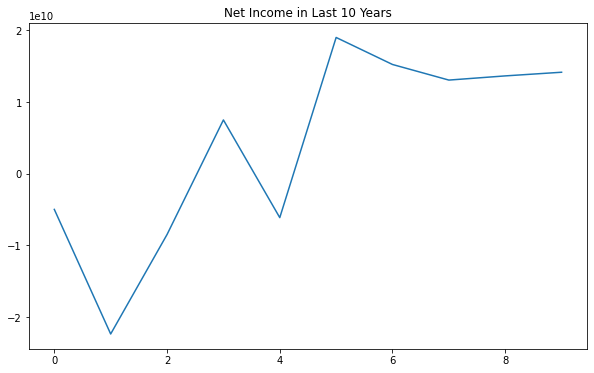

In [136]:
work_table['netIncome'].plot(figsize=(10,6), title="Net Income in Last 10 Years")

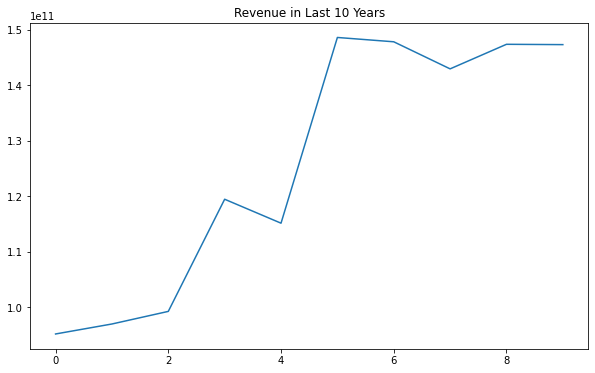

In [137]:
work_table['revenue'].plot(figsize=(10,6), title="Revenue in Last 10 Years")

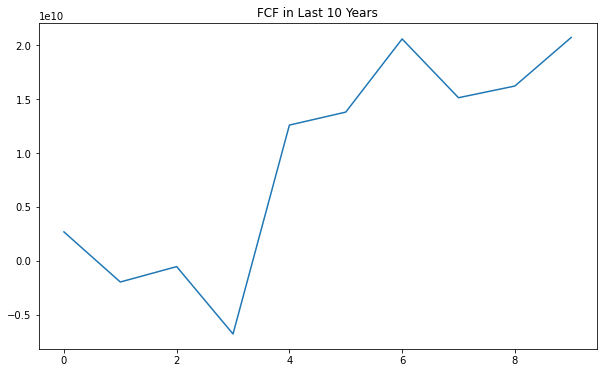

In [138]:
work_table['freeCashFlow'].plot(figsize=(10,6), title="FCF in Last 10 Years")

# Оцениваем инвестиционную стоимость  

In [139]:
print('Считаем инвестиционную стоимость по дивидендной модели Гордона')

def valuecompany(quote):
    Dtoday =   work_table['dividendsPaid'][0] / work_table['numberOfShares'][0]

    # ROE and PAyout Ratio

    ROE_formul = ROE_DuPont
    print(f'ROE_formul {ROE_formul}')

    payout_ratio = work_table['dividendPayoutRatio'][0]
    sustgrwothrate = ROE_formul * (1 - payout_ratio)

    ##Cost of equity:
    # Risk Free Rate
    start = datetime.datetime(2019, 2, 1)
    end= datetime.datetime.today().strftime('%Y-%m-%d')
    #end = datetime.datetime(2020, 2, 27)

    Treasury = wb.DataReader(['DGS10'], 'fred', start, end)
    RF = float(Treasury.iloc[-1])
    RF = RF / 100
    print(f'RF {RF}')

    # Beta
    beta = float(company_profile_beta)
    print(f'beta {beta}')

    # Market Return
    # Считаем годовую доходность
    data = wb.DataReader('^GSPC', data_source='yahoo', start='2001-1-1') # нужно определиться с переменной
    data['simple_return'] = (data['Adj Close'] / data['Adj Close'].shift(1)) - 1
    data['simple_return'].replace(np.nan, 0)
    avg_returns_a = data['simple_return'].mean() * 250

    print(f'Годовая доходность S&P500 {avg_returns_a*100}')

    # Drop all Not a number values using drop method.
    ke = RF + (beta * (avg_returns_a - RF))
    print(f'Стоимость капитала {ke*100}')

    DDM = (Dtoday * (1 + sustgrwothrate)) / (ke - sustgrwothrate)

    print(f'Расчетная стоимость по модели Гордона {DDM}')
    return DDM

valuecompany(COMPANY)

print(f'Время выполнения :{datetime.datetime.now() - start_time}') # Замер времени

Считаем инвестиционную стоимость по дивидендной модели Гордона
ROE_formul -0.00975
RF 0.006500000000000001
beta 1.177065
Годовая доходность S&P500 6.873573160722257
Стоимость капитала 7.975550142425544
Расчетная стоимость по модели Гордона -0.8104817786282731
Время выполнения :0:00:09.193340


# Расчет методом дисконтирования FCF спрогнозируемого методом динейной регрессии

In [140]:
# 'year_index' as the order of the year
work_table['year_index'] = range(1, len(work_table) + 1)[::-1]
# add intercept
work_table['intercept'] = 1

print(work_table)


# modeling
freeCashFlow_model = sm.OLS(work_table['freeCashFlow'], work_table[['year_index','intercept']]).fit()


freeCashFlow_pred_lr = freeCashFlow_model.predict([19,1])[0] #Прогнозируем через 10 лет


freeCashFlow_pred_lr5 = freeCashFlow_model.predict([14,1])[0] #Прогнозируем через 5 лет
freeCashFlow_pred_lr4 = freeCashFlow_model.predict([13,1])[0]
freeCashFlow_pred_lr3 = freeCashFlow_model.predict([12,1])[0]
freeCashFlow_pred_lr2 = freeCashFlow_model.predict([11,1])[0]
freeCashFlow_pred_lr1 = freeCashFlow_model.predict([10,1])[0]


# CAGR FCF

CF_forecast = {}

CF_forecast['next_year1'] = {}
CF_forecast['next_year1']['freeCashFlow'] = freeCashFlow_pred_lr1

CF_forecast['next_year2'] = {}
CF_forecast['next_year2']['freeCashFlow'] = freeCashFlow_pred_lr2

CF_forecast['next_year3'] = {}
CF_forecast['next_year3']['freeCashFlow'] = freeCashFlow_pred_lr3

CF_forecast['next_year4'] = {}
CF_forecast['next_year4']['freeCashFlow'] = freeCashFlow_pred_lr4

CF_forecast['next_year5'] = {}
CF_forecast['next_year5']['freeCashFlow'] = freeCashFlow_pred_lr5

print(CF_forecast)

print(f'freeCashFlow_pred_lr1 = {freeCashFlow_pred_lr1}')
print(f'freeCashFlow_pred_lr2 = {freeCashFlow_pred_lr2}')
print(f'freeCashFlow_pred_lr3 = {freeCashFlow_pred_lr3}')
print(f'freeCashFlow_pred_lr4 = {freeCashFlow_pred_lr4}')
print(f'freeCashFlow_pred_lr5 = {freeCashFlow_pred_lr5}')



print(freeCashFlow_pred_lr)


# ________________________________________  Расчет WACC  _______________________________________________


#Interest coverage ratio = EBIT / interest expenses

def interest_coveraga_and_RF(company):
  EBIT = work_table['ebitda'][0] - work_table['depreciationAndAmortization'][0]
  interest_expense = work_table['interestExpense'][0]
  interest_coverage_ratio = EBIT / interest_expense

    #RF
  start = datetime.datetime(1999, 12, 31)

  end= datetime.datetime.today().strftime('%Y-%m-%d')
  #end = datetime.datetime(2020, 7, 10)

  Treasury = wb.DataReader(['DGS10'], 'fred', start, end)
  RF = float(Treasury.iloc[-1])
  RF = RF/100
  print(f'RF,interest_coverage_ratio = {RF,interest_coverage_ratio}')
  return [RF,interest_coverage_ratio]


#Cost of debt
def cost_of_debt(company, RF,interest_coverage_ratio):
  if interest_coverage_ratio > 8.5:
    #Rating is AAA
    credit_spread = 0.0063
  if (interest_coverage_ratio > 6.5) & (interest_coverage_ratio <= 8.5):
    #Rating is AA
    credit_spread = 0.0078
  if (interest_coverage_ratio > 5.5) & (interest_coverage_ratio <=  6.5):
    #Rating is A+
    credit_spread = 0.0098
  if (interest_coverage_ratio > 4.25) & (interest_coverage_ratio <=  5.49):
    #Rating is A
    credit_spread = 0.0108
  if (interest_coverage_ratio > 3) & (interest_coverage_ratio <=  4.25):
    #Rating is A-
    credit_spread = 0.0122
  if (interest_coverage_ratio > 2.5) & (interest_coverage_ratio <=  3):
    #Rating is BBB
    credit_spread = 0.0156
  if (interest_coverage_ratio > 2.25) & (interest_coverage_ratio <=  2.5):
    #Rating is BB+
    credit_spread = 0.02
  if (interest_coverage_ratio > 2) & (interest_coverage_ratio <=  2.25):
    #Rating is BB
    credit_spread = 0.0240
  if (interest_coverage_ratio > 1.75) & (interest_coverage_ratio <=  2):
    #Rating is B+
    credit_spread = 0.0351
  if (interest_coverage_ratio > 1.5) & (interest_coverage_ratio <=  1.75):
    #Rating is B
    credit_spread = 0.0421
  if (interest_coverage_ratio > 1.25) & (interest_coverage_ratio <=  1.5):
    #Rating is B-
    credit_spread = 0.0515
  if (interest_coverage_ratio > 0.8) & (interest_coverage_ratio <=  1.25):
    #Rating is CCC
    credit_spread = 0.0820
  if (interest_coverage_ratio > 0.65) & (interest_coverage_ratio <=  0.8):
    #Rating is CC
    credit_spread = 0.0864
  if (interest_coverage_ratio > 0.2) & (interest_coverage_ratio <=  0.65):
    #Rating is C
    credit_spread = 0.1134
  if interest_coverage_ratio <=  0.2:
    #Rating is D
    credit_spread = 0.1512

  cost_of_debt = RF + credit_spread
  print(f'cost_of_debt = {cost_of_debt}')
  return cost_of_debt


def costofequity(company):

  #RF
  start = datetime.datetime(1999, 12, 31)
  end= datetime.datetime.today().strftime('%Y-%m-%d')
  #end = datetime.datetime(2020, 7, 10)

  Treasury = wb.DataReader(['DGS10'], 'fred', start, end)
  Treasury.dropna(inplace = True)
  RF = float(Treasury.iloc[-1])
  RF = RF/100


    #Beta
  beta = float(company_profile_beta)


  #Market Return
  data = wb.DataReader('^GSPC', data_source='yahoo', start='2001-1-1') # нужно определиться с переменной
  data['simple_return'] = (data['Adj Close'] / data['Adj Close'].shift(1)) - 1
  data['simple_return'].replace(np.nan, 0)
  avg_returns_a = data['simple_return'].mean() * 250
  #start = datetime.datetime(1999, 12, 31)
  #end= datetime.datetime.today().strftime('%Y-%m-%d')

  #SP500 = wb.DataReader(['sp500'], 'fred', start, end)

#Drop all Not a number values using drop method.
  #SP500.dropna(inplace = True)

  #SP500yearlyreturn = (SP500['sp500'].iloc[-1]/ SP500['sp500'].iloc[-252])-1

  cost_of_equity = RF+(beta*(avg_returns_a - RF))
  print(f'cost_of_equity = {cost_of_equity}')
  return cost_of_equity

#effective tax rate and capital structure
def wacc(company):

  ETR = work_table['effectiveTaxRate'][0]


  Debt_to = work_table['totalDebt'][0] / (work_table['totalDebt'][0] + work_table['totalStockholdersEquity'][0])
  equity_to = work_table['totalStockholdersEquity'][0] / (work_table['totalDebt'][0] + work_table['totalStockholdersEquity'][0])

  WACC = (kd*(1-ETR)*Debt_to) + (ke*equity_to)
  print(WACC,equity_to,Debt_to)
  print(f'WACC = {WACC}')
  return WACC


RF_and_IntCov = interest_coveraga_and_RF(COMPANY)
RF = RF_and_IntCov[0]
interest_coverage_ratio = RF_and_IntCov[1]
ke = costofequity(COMPANY)
kd = cost_of_debt(COMPANY, RF, interest_coverage_ratio)
wacc_company = wacc(COMPANY)
print('wacc of = ' + COMPANY + ' is \n' + str((wacc_company * 100)) + '%')


#FCF List of CFs for each year

CF_forec = pd.DataFrame.from_dict(CF_forecast,orient='columns')

FCF_List = CF_forec.iloc[0:].values.tolist()

# print(f'FCF_List = {FCF_List[0]}')


npv = npf.npv(wacc_company, FCF_List[0])
print(f'npv = {npv}')


#Terminal_value = (freeCashFlow_pred_lr5 * (1 + LTGrowth)) /(wacc_company  - LTGrowth)

#Terminal_value_Discounted = Terminal_value/( 1 + wacc_company) ** 4

Terminal_value_Discounted = freeCashFlow_pred_lr * (1 + LTGrowth) / (LTdis - LTGrowth)
print(f'Terminal_value_Discounted = {Terminal_value_Discounted}')

sum_num = npv + Terminal_value_Discounted
print(f'sum_num = {sum_num}')

spl_num = sum_num / work_table['numberOfShares'][0]
print(f'Estimated price = {spl_num}')

difference_model_and_market_value =  spl_num - PRICE
print(f'stock price = {PRICE}')

print(f'difference_model_and_market_value = {difference_model_and_market_value}')

         date       revenue  operatingIncome    netIncome       eps  \
0  2019-12-31   95215000000       3470000000  -4979000000  0.284460   
1  2018-12-31   97012000000     -17537000000 -22354000000 -0.741000   
2  2017-12-31   99279000000      -8470000000  -8484000000 -0.192700   
3  2016-12-31  119468000000      10223000000   7500000000  0.581040   
4  2015-12-31  115158000000       8141000000  -6126000000  0.282140   
5  2015-02-27  148589000000      15457000000  19001000000  0.015233   
6  2014-12-31  147811000000      17824000000  15233000000  1.480000   
7  2013-12-31  142937000000      15669000000  13057000000  1.280000   
8  2012-12-31  147359000000      18217000000  13641000000  1.470000   
9  2011-12-31  147300000000      20798000000  14151000000  1.230000   

        ebitda  depreciationAndAmortization  interestExpense   totalAssets  \
0   -110000000                 5.595000e+09              0.0  266048000000   
1 -16355000000                 6.582000e+09              0.0  

<ipython-input-140-93f7c8b36921>:63: RuntimeWarning: divide by zero encountered in double_scalars
  interest_coverage_ratio = EBIT / interest_expense


RF,interest_coverage_ratio = (0.006500000000000001, -inf)
cost_of_equity = 0.07975550142425544
cost_of_debt = 0.1577
0.21515658307434082 0.23755432138123123 0.7624456786187688
WACC = 0.21515658307434082
wacc of = GE is 
21.515658307434084%
npv = -26320854414.892326
Terminal_value_Discounted = -470407927272.7272
sum_num = -496728781687.6195
Estimated price = -56.938191390144375
stock price = 6.31
difference_model_and_market_value = -63.24819139014438


# Стоимость акции по дивам и балансовой стоимости(линейная регрессия)

In [141]:
dvd_avg = np.mean((work_table['Dividend per Share']).astype(float))  # Определим средний дивиденд
print(dvd_avg)


0.09321125302037


In [142]:
start = datetime.datetime(1999, 12, 31)
end= datetime.datetime.today().strftime('%Y-%m-%d')
Treasury = wb.DataReader(['DGS10'], 'fred', start, end)
RF = float(Treasury.iloc[-1])
risk_free_rate = RF/100
# The discounted capital for the dividend of 3-year later
dvd_avg / (1 + risk_free_rate) ** 3
# The discounted capital for the dividend of 10-year later
# dvd_avg/(1+risk_free_rate)**10

0.09141700913101179

In [143]:
dvd_total = 0
for j in range(1, 11):
    dvd_total = dvd_total + dvd_avg / (1 + risk_free_rate) ** j
print(dvd_total)

0.8996379309502957


In [144]:
growth_rate_of_10y = (work_table['bookValuePerShare'][0]) / (work_table['bookValuePerShare'][9])
avg_growth_rate = growth_rate_of_10y ** (1 / 10)
print(avg_growth_rate)

0.8853899797835171


In [145]:
bvps_pred = (work_table['bookValuePerShare'][0]) * (avg_growth_rate ** 10)
print(bvps_pred)

0.9608647761233379


In [146]:
data_intrinsic = bvps_pred + dvd_total
print(data_intrinsic)

1.8605027070736335


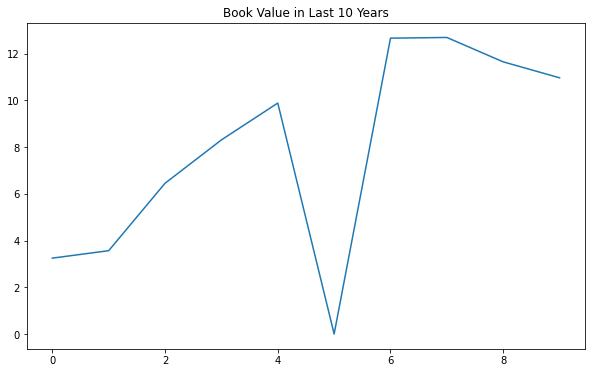

In [147]:
work_table['bookValuePerShare'].plot(figsize=(10,6), title="Book Value in Last 10 Years")

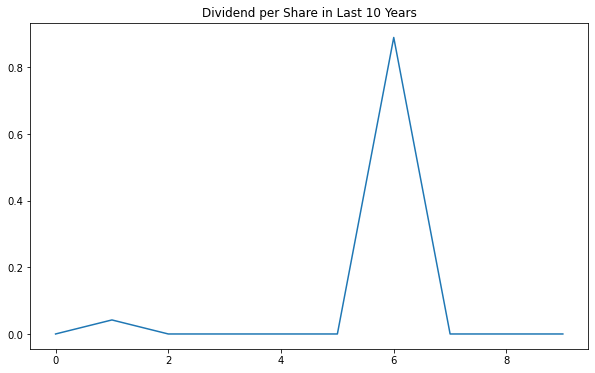

In [148]:
work_table['Dividend per Share'].astype('float').plot(figsize=(10,6), title="Dividend per Share in Last 10 Years")

In [149]:
# 'year_index' as the order of the year
work_table['year_index'] = range(1, len(work_table) + 1)[::-1]
# add intercept
work_table['intercept'] = 1

In [150]:
# modeling
bvps_model = sm.OLS(work_table['bookValuePerShare'], work_table[['year_index', 'intercept']]).fit()

In [151]:
bvps_pred_lr = bvps_model.predict([19, 1])[0]  # Прогнозируем балансовую стоимость через 10 лет
print(f'bvps_pred_lr через 10 лет: {bvps_pred_lr}' )

bvps_pred_lr через 10 лет: -5.1838492972489725


In [152]:
dvd_model = sm.OLS((work_table['Dividend per Share']).astype(float), work_table[['year_index', 'intercept']]).fit()

dvd_model.predict([19, 1])[0]  # Определить дивиденд через 10 лет

-0.10112429786296542

In [153]:
# Дивиденды за 10 лет
dvd_total_lr = 0
current_year_order = 9
for j in range(1, 11):
    dvd_new = dvd_model.predict([current_year_order + j, 1])[0]
    dvd_total_lr = dvd_total_lr + dvd_new / (1 + risk_free_rate) ** j
print(f'dvd_total_lr: {dvd_total_lr}' )

dvd_total_lr: -0.3433691555267789


In [154]:
aapl_intrinsic_lr = dvd_total_lr + bvps_pred_lr
print(f'aapl_intrinsic_lr: {aapl_intrinsic_lr}' )

aapl_intrinsic_lr: -5.5272184527757515


In [155]:
difference_model_and_market_value = aapl_intrinsic_lr - PRICE
print(f'stock price = {PRICE}')
print(f'difference_model_and_market_value = {difference_model_and_market_value}')

stock price = 6.31
difference_model_and_market_value = -11.837218452775751


# Оценка дисперсии модели линейной регресси дивов через R-Squared

0                0.0
1    0.0421125302037
2                0.0
3                0.0
4                0.0
5                0.0
6               0.89
7                0.0
8                0.0
9                0.0
Name: Dividend per Share, dtype: object
          y   x
0  0.000000  10
1  0.042113   9
2  0.000000   8
3  0.000000   7
4  0.000000   6
5  0.000000   5
6  0.890000   4
7  0.000000   3
8  0.000000   2
9  0.000000   1


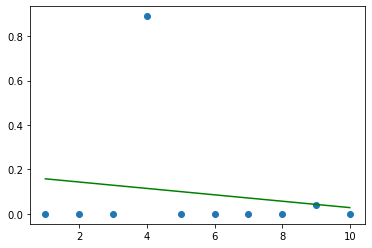

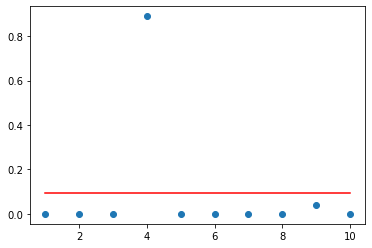

0.7069900883038831
The rsquared value is: 0.02418118601457586


In [156]:
# # creating OLS regression

print(work_table['Dividend per Share'])

r2_table = pd.DataFrame()
r2_table['y'] = work_table['Dividend per Share'][0:10].replace(np.nan, 0).replace('', 0, regex=True).astype(float)
r2_table['x'] = work_table['year_index']

print(r2_table)


slope, intercept, r_value, p_value, std_err = stats.linregress(r2_table['x'], r2_table['y'])
def linefitline(b):
    return intercept + slope * b

# line1 = linefitline(r2_table['x'])
line1 = linefitline(r2_table['x'])


#plot line
plt.scatter(r2_table['x'], r2_table['y'])
plt.plot(r2_table['x'], line1, c='g')
plt.show()


line2 = np.full(10, [r2_table['y'].mean()])
plt.scatter(r2_table['x'], r2_table['y'])
plt.plot(r2_table['x'], line2, c='r')
plt.show()

differences_line1 = linefitline(r2_table['x']) - r2_table['y']
line1sum = 0
for k in differences_line1:
    line1sum = line1sum + (k * k)

differences_line2 = line2 - r2_table['y']
line2sum = 0
for k in differences_line2:
    line2sum = line2sum + (k * k)

print(line2sum)

r2 = r2_score(r2_table['y'], linefitline(r2_table['x']))
print('The rsquared value is: ' + str(r2))

# Оценка дисперсии модели линейной регресси FCF через R-Squared

             y   x
0   2678000000  10
1  -1968000000   9
2   -541000000   8
3  -6788000000   7
4  12583000000   6
5  13788000000   5
6  20572000000   4
7  15121000000   3
8  16205000000   2
9  20709000000   1


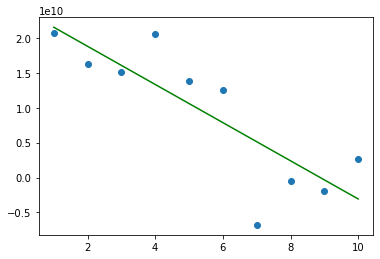

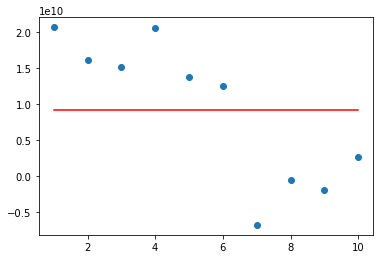

8.961532089e+20
The rsquared value is: 0.6880508999692089


In [157]:
# # creating OLS regression


r2_table_FCF = pd.DataFrame()
r2_table_FCF['y'] = work_table['freeCashFlow'].replace(np.nan, 0).replace('', 0, regex=True)
r2_table_FCF['x'] = work_table['year_index']

print(r2_table_FCF)

slope, intercept, r_value, p_value, std_err = stats.linregress(r2_table_FCF['x'], r2_table_FCF['y'])


def linefitline(b):
    return intercept + slope * b


# line1 = linefitline(r2_table['x'])
line1 = linefitline(r2_table_FCF['x'])

# plot line
plt.scatter(r2_table_FCF['x'], r2_table_FCF['y'])
plt.plot(r2_table_FCF['x'], line1, c='g')
plt.show()

line2 = np.full(10, [r2_table_FCF['y'].mean()])
plt.scatter(r2_table_FCF['x'], r2_table_FCF['y'])
plt.plot(r2_table_FCF['x'], line2, c='r')
plt.show()

differences_line1 = linefitline(r2_table_FCF['x']) - r2_table_FCF['y']
line1sum = 0
for k in differences_line1:
    line1sum = line1sum + (k * k)

differences_line2 = line2 - r2_table_FCF['y']
line2sum = 0
for k in differences_line2:
    line2sum = line2sum + (k * k)

print(line2sum)

r2_FCF = r2_score(r2_table_FCF['y'], linefitline(r2_table_FCF['x']))
print('The rsquared value is: ' + str(r2_FCF))